# Parameters
### Stock Parameters
1. $\sigma$ — volatility: estimate using rolling window returns standard deviation (choose step and window size)
### Objective Parameters
1. $\gamma$ — risk-aversion: TODO: look at interpretation
1. $w$ — maximum position size
### Market Orders Parameters
1. $\alpha$ — market order size: estimate using rolling window mean with correction for current time average order size (choose the method for correction for time of the day)
1. $\beta, K$ — market impact: estimate from orderbook (use cumulative order size on various levels).
1. $\Lambda$ — trading intensity scale: estimate using exponential distribution time between orders for current time (choose the method for correction of intensity for time of the day) 

# Dynamics:
## Stock
$$dS = \sigma dW$$

## Market Orders

### Poisson process

We place orders on $p^b = s - \delta^b$ and $p^a = s + \delta^a$.

Buy orders: Poisson rate $\lambda^a(\delta^a)$

Sell orders: Poisson rate $\lambda^b(\delta^b)$

$\lambda^{a, b}(\delta)$ — a decreasing function of $\delta$ (the worse the prices the fewer transactions)

### Trading intensity: lambda(delta)

The density of market order size:
$$f^{Q}(x) \propto \alpha x^{-1 - \alpha}$$
$\alpha = 1.53, 1.4, 1.5$

Market impact:
$$\Delta p \propto Q^{\beta}$$
$\beta = 0.5, 0.76$
$$\Delta p \propto \ln(Q)$$

Trading intensity:
$$\lambda(\delta) = \Lambda P(\Delta p > \delta) = \Lambda P(\ln(Q) > K \delta) = \Lambda P(Q > \exp(K \delta)) = \Lambda \int\limits_{\exp(K\delta)}^{+\infty} \alpha x^{-1 - \alpha} dx = \Lambda e^{\alpha K \delta} = \Lambda e^{-k \delta}$$
where $k = \alpha K$.

In case of $\Delta p \propto Q^{\beta}$:
$$\lambda(\delta) = \Lambda \int\limits_{(K\delta)^{\frac{1}{\beta}}}^{+\infty} \alpha x^{-1 - \alpha} dx = \Lambda K^{-\frac{\alpha}{\beta}} \delta^{-\frac{\alpha}{\beta}}$$

Alternatively. market impact function $\Delta p (Q)$ can be derived directly by integrating the density of the limit order book.

## Capital
Number of dollars held:
$$dX_t = p^a dN_t^a - p^b dN_t^b$$
Number of stocks held:
$$q_t = N_t^b - N_t^a$$

# Objective:
$$v(x, s, q, t) = \mathbb{E}_t[-\exp(-\gamma(x + q S_T)] = -\exp(-\gamma x) \cdot \exp(-\gamma q s) \cdot \exp\left(\frac{\gamma^2 q^2 \sigma^2 (T - t)}{2}\right)$$
1. $x$ — initial wealth in dollars
1. $S_t = s$ — initial stock price
1. $q$ — number of stocks at terminal time $T$
1. $t$ — start time
1. $S_T$ - terminal stock price

### Infinite horizon:
$$\bar v(x, s, q) = \mathbb{E}\left[\int\limits_{0}^{+\infty} -\exp(-wt)\exp(-\gamma(x + q S_t)) dt\right]$$

# Solution:

## Reservation bid/ask prices
$r^b$ and $r^a$ — the prices at which the agent is indifferent between buying/selling 1 security:
$$v(x - r^b(s, q, t), s, q + 1, t) = v(x, s, q, t)$$
$$v(x + r^a(s, q, t), s, q - 1, t) = v(x, s, q, t)$$
Closed form solution:
$$r^a(s, q, t) = s + (1 - 2q)\frac{\gamma \sigma^2 (T - t)}{2}$$
$$r^b(s, q, t) = s + (-1 - 2q)\frac{\gamma \sigma^2 (T - t)}{2}$$
$$r^{a, b}(s, q, t) = s - 2q \frac{\gamma \sigma^2 (T - t)}{2} \pm \frac{\gamma \sigma^2 (T - t)}{2}$$

## Reservation (indifference) price
The average of reservation bid/ask prices:
$$r(s, q, t) = s - q \gamma \sigma^2 (T - t)$$

## Infinite horizon reservation price
$$\bar r^a(s, q) = s + \frac{1}{\gamma} \ln\left(1 + \frac{(1 - 2q) \gamma^2 \sigma^2}{2w - \gamma^2 q^2 \sigma^2}\right)$$
$$\bar r^b(s, q) = s + \frac{1}{\gamma} \ln\left(1 + \frac{(-1 - 2q) \gamma^2 \sigma^2}{2w - \gamma^2 q^2 \sigma^2}\right)$$
where $w > \frac{1}{2} \gamma^2 \sigma^2 q^2$

$w$ reflects the upper bound on $q$, so we can choose:
$$w = \frac{1}{2} \gamma^2 \sigma^2 (q_{max} + 1)^2$$
This means that:
$$q = q_{max} \Rightarrow r^b = -\infty,\, r^a = s + \frac{1}{\gamma} \ln \frac{2}{1 + 2q_{max}}$$
$$q = -q_{max} \Rightarrow r^a = +\infty,\, r^b = s + \frac{1}{\gamma} \ln \left(2 - \frac{2}{1 + 2q_{max}}\right)$$

## Optimal quotes
They are given by implicit relations:
$$s - r^b(s, q, t) = \delta^b - \frac{1}{\gamma} \ln\left(1 - \gamma \frac{\lambda^b(\delta^b)}{\frac{\partial \lambda^b}{\partial \delta}(\delta^b)}\right)$$
$$r^a(s, q, t) - s = \delta^a - \frac{1}{\gamma} \ln\left(1 - \gamma \frac{\lambda^a(\delta^a)}{\frac{\partial \lambda^a}{\partial \delta}(\delta^a)}\right)$$

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [267]:
import typing as tp
from dataclasses import dataclass


@dataclass
class SimulationsResult:
    q: list[int]
    X: list[float]
    delta_a: list[float]
    delta_b: list[float]
    intensity_a: list[float]
    intensity_b: list[float]
    average_spread: list[float]
    pnl: list[float]

class StoikovModel:
    def __init__(
        self,
        dt: float, T: float,
        S_0: float, sigma: float,
        gamma: float, k: float,
        lambda_intensity_function: tp.Callable[[float], float],  # delta -> intensity
        num_of_simulations = 1000,
        seed: int = 1
    ) -> None:
        np.random.seed(seed)
        self.dt = dt
        self.k=k
        self.T = T
        self.n = round(T / dt)
        self.t = np.arange(0, self.T + self.dt, self.dt)

        self.S_0 = S_0
        self.sigma = sigma
        self.gamma = gamma
        self.num_of_simulations = num_of_simulations

        self.lambda_intensity_function = lambda_intensity_function

        # Calculate S
        self.S = self._get_s()
        
    def _get_s(self):
        # dS = sigma dW
        S = [[self.S_0] * (self.n + 1)] * self.num_of_simulations 
        S = np.array(S)
        for i in range(self.num_of_simulations):
            dW = np.random.standard_normal(size=self.n) * np.sqrt(self.dt)  # N(0, dt)
            S[i][:] = self.S_0 + self.sigma * np.hstack(([0], np.cumsum(dW)))[:]
            #S:
            # S_0 S_1 .. S_n
            # S_0 S_1 .. S_n
            # .
            # .
            # S_0 S_1 .. S_n
        return S

    def simulate(self, delta_a_func: tp.Callable[[float, int], float], delta_b_func: tp.Callable, seed: int = 1, strategy = "inv") -> SimulationsResult:
        np.random.seed(seed)
        average_spread = []
        k=self.k
        pnl = [0] * self.num_of_simulations
        
        for n_sim in range(self.num_of_simulations):

            delta_a_values = [0]
            delta_b_values = [0]
            intensity_a_values = []
            intensity_b_values = []
            spread = np.zeros((self.n+1))
            X = [0]
            q = [0]
            spread[0] = 0
            
            if strategy == "inv":
                for i in range(1,self.n+1):
                    S = self.S[n_sim][i]
                    orders_a, delta_a, intensity_a = self._get_n_orders_executed(delta_a_func, S, q[-1], self.T-self.dt*i)
                    orders_b, delta_b, intensity_b = self._get_n_orders_executed(delta_b_func, S, q[-1], self.T-self.dt*i)
                    q.append(q[-1] + orders_b - orders_a)
                    X.append(X[-1] - orders_b * (S - delta_b) + orders_a * (S + delta_a)) # delta_b = s - res_b, delta_a = res_a - s 
                    pnl[n_sim] = X[-1]
                    spread[i] = self.gamma * (self.gamma**2) * (self.T - self.dt*i) + 2/(self.gamma) * np.log(1+self.gamma/k)
                    delta_a_values.append(delta_a)
                    delta_b_values.append(delta_b)
                    intensity_a_values.append(intensity_a)
                    intensity_b_values.append(intensity_b)           
            else:   #sym_strategy:
                for i in range(1,self.n+1):
                    S = self.S[n_sim][i]
                    orders_a, delta_a, intensity_a = self._get_n_orders_executed(delta_a_func, S, q[-1], self.T-self.dt*i)
                    orders_b, delta_b, intensity_b = self._get_n_orders_executed(delta_b_func, S, q[-1], self.T-self.dt*i)
                    q.append(q[-1] + orders_b - orders_a)
                    X.append(X[-1] - orders_b * (S - delta_b) + orders_a * (S + delta_a)) # delta_b = s - res_b, delta_a = res_a - s 
                    pnl[n_sim] = X[-1]
                    spread[i] = self.gamma * (self.gamma**2) * (self.T - self.dt*i) + 2/(self.gamma) * np.log(1+self.gamma/k)
                    delta_a_values.append(delta_a)
                    delta_b_values.append(delta_b)
                    intensity_a_values.append(intensity_a)
                    intensity_b_values.append(intensity_b) 
                
            average_spread.append(spread.mean())
            pnl[n_sim] += q[-1] * S

        return SimulationsResult(
            X=np.array(X),
            q=np.array(q),
            delta_a=np.array(delta_a_values),
            delta_b=np.array(delta_b_values),
            intensity_a=np.array(intensity_a_values),
            intensity_b=np.array(intensity_b_values),
            average_spread = np.array(average_spread),
            pnl = np.array(pnl),
        )

    def _get_n_orders_executed(self, delta_function: tp.Callable[[float, float], float], S, q, i):  # i = dt = (T-t)
        delta = delta_function(self.gamma, self.sigma, S, q, i, self.k)
        if abs(delta) > 10000:
            delta = 0
        lambda_intensity = self.lambda_intensity_function(delta)
        n_orders = self._poisson_process(lambda_intensity)
        return n_orders, delta, lambda_intensity

    def _poisson_process(self, lambda_intensity: float):
        return np.random.poisson(lam=lambda_intensity * self.dt)

    
def reservation_ask(gamma,sigma,s,q,dt,k):  #dt = (T-t)
    r = reservation_price(gamma,sigma,s,q,dt)
    sum_of_deltas = gamma * (sigma**2)* dt + 2/gamma * np.log(1+gamma/k)    
    res_ask = r + sum_of_deltas/2 
    return res_ask
    
def reservation_bid(gamma,sigma,s,q,dt,k):  #dt = (T-t)
    r = reservation_price(gamma,sigma,s,q,dt)
    sum_of_deltas = gamma * (sigma**2)* dt + 2/gamma * np.log(1+gamma/k)    
    res_bid = r - sum_of_deltas/2 
    return res_bid

def reservation_ask_sym(s, delta_a_value):  
    return (s + delta_a_value) if (delta_a_value < 1000) else s
    
def reservation_bid_sym(s, delta_b_value):  
    return (s - delta_b_value) if (delta_b_value < 1000) else s
    

def reservation_price(gamma,sigma,s,q,dt):  #dt = (T-t)
    return s-q*gamma*(sigma**2)*dt

# def reservation_price_sym(gamma,sigma,s,q,dt):  #dt = (T-t)
#     return (reservation_ask_sym(gamma,sigma,s,q,dt,k) + reservation_bid_sym(gamma,sigma,s,q,dt,k))/2

def get_delta_function(is_bid: bool, max_q, fixed_spread=0, inf_spread=10000, strategy = "inv"):
    def simple_delta(gamma, sigma, S, q, dt, k):
        if is_bid and q >= max_q or not is_bid and q <= -max_q:
            return inf_spread
        if strategy=="inv":
            return (S-reservation_bid(gamma,sigma,S,q,dt,k)) if is_bid else (reservation_ask(gamma,sigma,S,q,dt,k) - S) 
        else:
            return (reservation_price(gamma,sigma,S,q,dt)-reservation_bid(gamma,sigma,S,q,dt,k)) if is_bid else (reservation_ask(gamma,sigma,S,q,dt,k) - reservation_price(gamma,sigma,S,q,dt)) 
    return simple_delta
        

In [268]:
@dataclass
class StrategyResults:
    model: StoikovModel
    simulation_results: SimulationsResult
    capital: list[float]
    returns: list[float]  # capital.diff()
    mu: float  # returns.mean()
    std: float  # returns.std()
    sharpe: float  # mu / std

    def print(self):
        print(f'Sharpe: {self.sharpe:.3f} | {self.mu:.3f} ± {self.std:.3f}')


def get_strategy_results(model: StoikovModel, simulation_results: SimulationsResult) -> StrategyResults:
    capital = simulation_results.q * model.S[model.num_of_simulations-1][:] + simulation_results.X

    returns = np.diff(capital) 
    mu = returns.mean()
    std = returns.std()
    sharpe = mu / std

    return StrategyResults(
        model=model,
        simulation_results=simulation_results,
        capital=capital,
        returns=returns,
        mu=returns.mean(),
        std=returns.std(),
        sharpe=sharpe
    )

In [269]:
def get_trading_intensity(Lambda: float, k: float) -> tp.Callable[[float], float]:
    return lambda delta: Lambda * np.exp(-k * delta)


model = StoikovModel(
    dt=0.005, T=1,
    S_0=100., sigma=2,
    gamma=0.1, k=1.5,
    lambda_intensity_function=get_trading_intensity(Lambda=140, k=1.5)
)

model_sym = StoikovModel(
    dt=0.005, T=1.,
    S_0=100., sigma=2,
    gamma=0.1, k=1.5,
    lambda_intensity_function=get_trading_intensity(Lambda=140, k=1.5)
)
# plt.plot(model.t, model.S)
# plt.show()



MAX_Q = 10
simulation_results = model.simulate(
    delta_a_func=get_delta_function(is_bid=False, max_q=MAX_Q),
    delta_b_func=get_delta_function(is_bid=True, max_q=MAX_Q)
)
result = get_strategy_results(model, simulation_results)
result.print()

strategy="sym"
simulation_results_sym = model_sym.simulate(
    delta_a_func=get_delta_function(is_bid=False, max_q=MAX_Q, strategy ="sym"),
    delta_b_func=get_delta_function(is_bid=True, max_q=MAX_Q, strategy ="sym")
)
result_sym = get_strategy_results(model_sym, simulation_results_sym)
result_sym.print()



Sharpe: 0.688 | 0.345 ± 0.502
Sharpe: 0.355 | 0.372 ± 1.049


+-------------+-------------+--------------+---------------+
| Strategy    |    Spread   |     Profit   |   std(Profit) |
+=============+=============+==============+===============+
| Invenory    |     1.28484 |      62.9797 |       7.36239 |
+-------------+-------------+--------------+---------------+
| Symmetric   |     1.28484 |      66.0695 |      12.5574  |
+-------------+-------------+--------------+---------------+


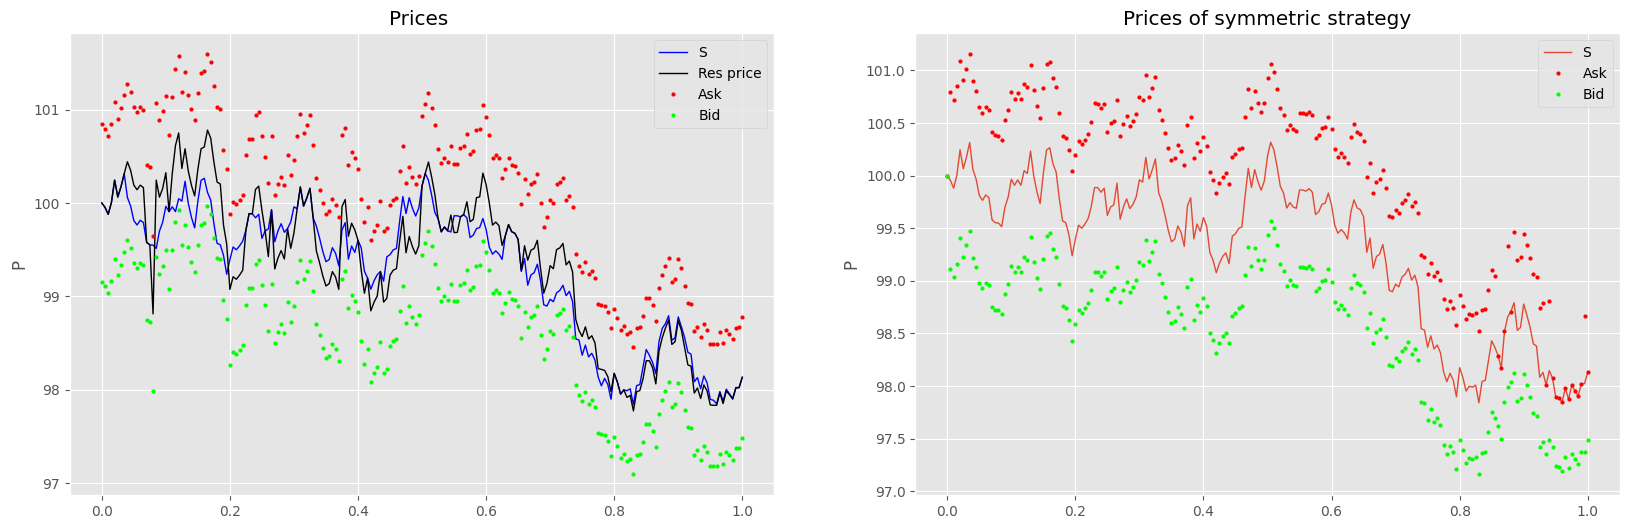

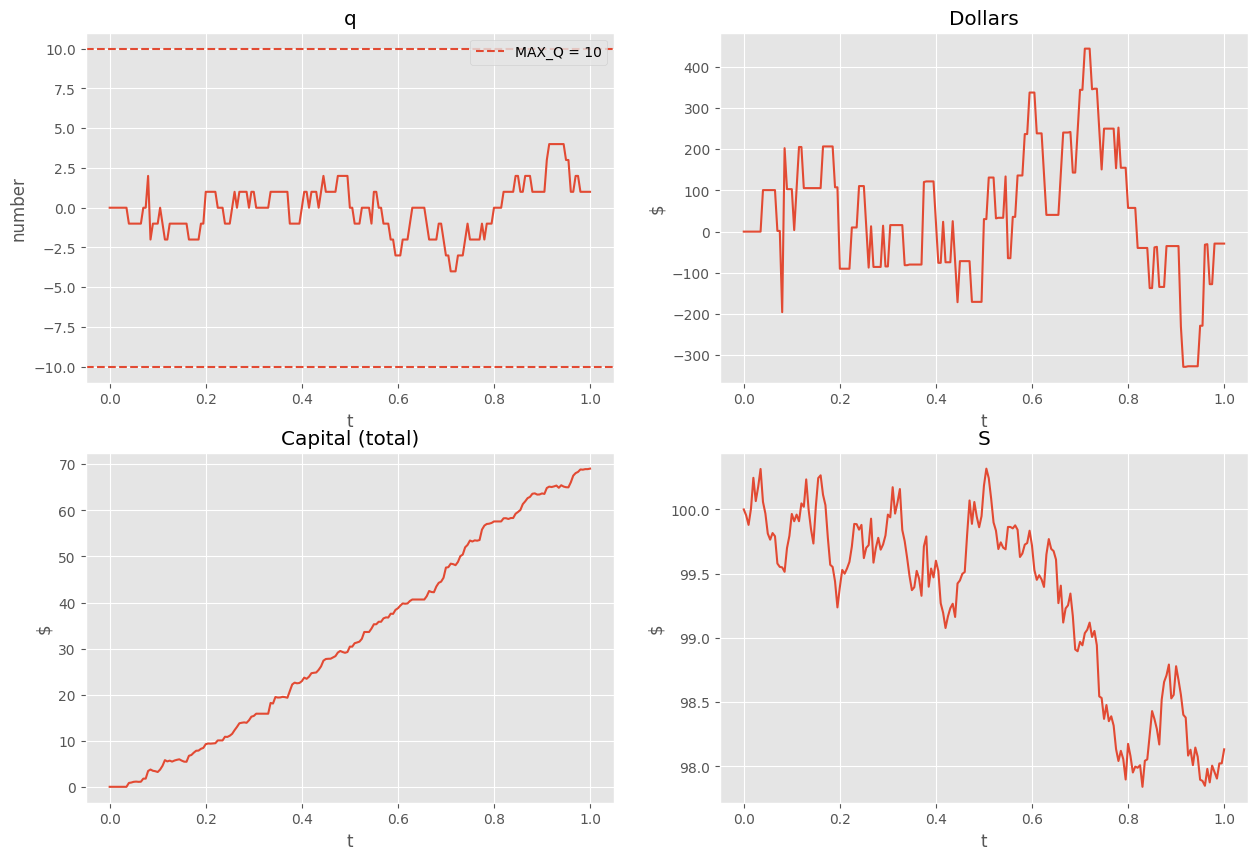

In [272]:

from tabulate import tabulate

data = [
    ["Invenory ", simulation_results.average_spread.mean(), (simulation_results.pnl).mean(),(simulation_results.pnl).std() ], 
    ["Symmetric", simulation_results_sym.average_spread.mean(),simulation_results_sym.pnl.mean(),simulation_results_sym.pnl.std() ], 
]

# create header
head = ["Strategy ", " Spread  ", "  Profit  ", "std(Profit)"]
 
# display table
print(tabulate(data, headers=head, tablefmt="grid"))


x = np.linspace(0., model.T, num= (model.n+1))
#fig=plt.figure(figsize=(15,8))  
plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(x, model.S[model.num_of_simulations-1][:], lw = 1., color = 'blue', label = 'S')
plt.plot(x, reservation_price(model.gamma, model.sigma, model.S[model.num_of_simulations-1][:],simulation_results.q[:], model.T - x[:]), lw = 1., color='black', label = 'Res price')
plt.plot(x, reservation_ask(model.gamma,   model.sigma, model.S[model.num_of_simulations-1][:],simulation_results.q[:], model.T - x[:], model.k), lw = 1., color='red', linestyle='', marker='.', label = 'Ask',markersize='4')
plt.plot(x, reservation_bid(model.gamma,   model.sigma, model.S[model.num_of_simulations-1][:],simulation_results.q[:], model.T - x[:], model.k), lw = 1., color='lime', linestyle='', marker='o', label = 'Bid', markersize='2')       
plt.grid(True)
plt.legend(loc=0)
plt.ylabel('P')
plt.title('Prices ')


r_a_sym = np.empty(model_sym.n+1)
#r_a_sym[:] = reservation_ask_sym(model_sym.S[model_sym.num_of_simulations-1][:], simulation_results_sym.delta_a[:])
for i in range(model_sym.n+1):
    r_a_sym[i] = reservation_ask_sym(model_sym.S[model_sym.num_of_simulations-1][i], simulation_results_sym.delta_a[i])



r_b_sym = np.empty(model_sym.n+1)
#r_b_sym[:] = reservation_bid_sym(model_sym.S[model_sym.num_of_simulations-1][:], simulation_results_sym.delta_a[:])
for i in range(model_sym.n+1):
    r_b_sym[i] = reservation_bid_sym(model_sym.S[model_sym.num_of_simulations-1][i], simulation_results_sym.delta_b[i])


plt.subplot(1, 2, 2)
plt.plot(x , model_sym.S[model_sym.num_of_simulations-1][:], lw = 1., label = 'S')
#plt.plot(x, reservation_price(  model_sym.gamma,   model_sym.sigma, model_sym.S[model_sym.num_of_simulations-1][:],simulation_results_sym.q[:], model_sym.T - x[:]), lw = 1., color='black', label = 'Res price')
plt.plot(x, r_a_sym, lw = 1., color='red', linestyle='', marker='.', label = 'Ask',markersize='4')
plt.plot(x, r_b_sym, lw = 1., color='lime', linestyle='', marker='o', label = 'Bid', markersize='2')       
plt.grid(True)
plt.legend(loc=0)
plt.ylabel('P')
plt.title('Prices of symmetric strategy')




plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.t, simulation_results.q)
plt.xlabel('t')
plt.title('q')
plt.ylabel('number')
plt.axhline(MAX_Q, linestyle='--', label=f'{MAX_Q = }')
plt.axhline(-MAX_Q, linestyle='--')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model.t, simulation_results.X)
plt.xlabel('t')
plt.title('Dollars')
plt.ylabel('$')

plt.subplot(2, 2, 3)
plt.plot(model.t, result.capital)
plt.xlabel('t')
plt.title('Capital (total)')
plt.ylabel('$')


plt.subplot(2, 2, 4)
plt.plot(model.t, model.S[model.num_of_simulations-1][:])
plt.xlabel('t')
plt.title('S')
plt.ylabel('$')

plt.show()

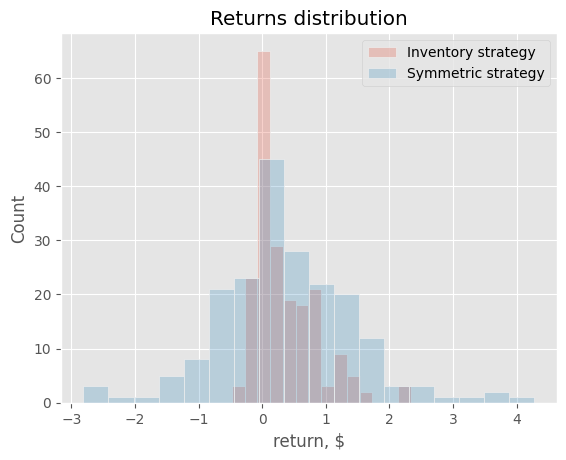

In [255]:
sns.histplot(result.returns,    alpha=0.25, label="Inventory strategy")
sns.histplot(result_sym.returns,alpha=0.25, label="Symmetric strategy")
plt.legend()
plt.title('Returns distribution')
plt.xlabel('return, $')
plt.show()

